# Import Data

In [1]:
!wget -O input.txt "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"


--2024-09-19 08:00:39--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2024-09-19 08:00:39 (47.8 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [89]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [88]:
batch_size=16 #independent sequences process in parallel
block_size=40 #context length for predictions
max_iters = 10000
eval_interval = 100
learning_rate = 3e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
with open ("input.txt" , 'r', encoding="utf-8") as f:
  text=f.read()

In [5]:
chars=sorted(list(set(text)))
vocab_size=len(chars)

# Define Encoder and Decoder

In [6]:
stoi={ch:i for i,ch in enumerate(chars)} #string to int
itos={i:ch for i,ch in enumerate(chars)} #int to string
encode = lambda s:[stoi[c] for c in s] #take a string and return a list of int
decode = lambda s:"".join([itos[c] for c in s]) #take a list of int and return a str

# Data Encoding and Data Split

In [7]:
data=torch.tensor(encode(text),dtype=torch.long)
n=int(0.9*len(data))
train_data=data[:n]
val_data=data[n:]

# Data Loading

In [9]:
def get_batch(split):
  data=train_data if split=="train" else val_data
  ix =torch.randint(len(data)-block_size,(batch_size,)) #we can not go over block_size
  x=torch.stack([data[i:i+block_size] for i in ix])
  y=torch.stack([data[i+1:i+block_size+1] for i in ix])
  x,y=x.to(device), y.to(device)
  return x,y
# get_batch("train")

(tensor([[43, 52,  1, 46, 43, 56, 43,  6],
         [39, 52, 42,  1, 59, 57, 11,  0],
         [ 1, 41, 53, 59, 57, 47, 52,  1],
         [32, 39, 49, 43,  1, 59, 54,  1]], device='cuda:0'),
 tensor([[52,  1, 46, 43, 56, 43,  6,  1],
         [52, 42,  1, 59, 57, 11,  0, 32],
         [41, 53, 59, 57, 47, 52,  1, 57],
         [39, 49, 43,  1, 59, 54,  1, 58]], device='cuda:0'))

In [77]:
@torch.no_grad()
def estimate_loss(eval_iters):
  out={}
  model.eval()
  for split in ["train","val"]:
    losses=torch.zeros(eval_iters)
    for k in range(eval_iters):
      X,Y=get_batch(split)
      logits,loss=model(X,Y)
      losses[k]=loss.item()
    out[split]=losses.mean()
  model.train()
  return out

# Bigram Model

In [91]:
class BigramLanguageModel(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.token_embedding_table=nn.Embedding(vocab_size,vocab_size) #for each char in data, attribute a number for each str in vocab

  def forward(self,idx,targets=None):
    #idx (x) and targets (y) are shapes (B,T)

    logits=self.token_embedding_table(idx) #(Batch (number of sequences), Time (len of sequences), Channel (vocab_size))

    if targets is None:
      loss=None
    else:
      B,T,C=logits.shape
      logits_reshape=logits.view(B*T,C) #reshape (concatenate)
      targets=targets.view(B*T)
      loss=F.cross_entropy(logits_reshape,targets)
    return logits,loss

  def generate(self,idx,max_new_tokens):
    for _ in range(max_new_tokens):
      logits,loss=self.forward(idx)
      logits=logits[:,-1,:] #take the 2 last str of each sequences for every batches -> become (B,C)
      probs=F.softmax(logits,dim=-1) #get probabilites from logits
      idx_next=torch.multinomial(probs,num_samples=1) #take a list of probabilites and return the index of the prob in the list which as been peeked
      idx=torch.cat((idx,idx_next),dim=1) #concatenate the input (idx) and the predictions which as been made
    return idx

In [92]:
model=BigramLanguageModel(vocab_size).to(device)

In [93]:
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)

# Model Training

In [94]:
history={"train":[],"val":[]}
for iter in range(max_iters):
  if iter%eval_interval==0:
    losses=estimate_loss(100)
    history["train"].append(losses["train"])
    history["val"].append(losses["val"])

    print(f"Step {iter} - Train Loss : {losses['train']:.4f} Val Loss : {losses['val']:.4f}")
  xb,yb=get_batch("train")
  logits,loss=model(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()


Step 0 - Train Loss : 4.5366 Val Loss : 4.5559
Step 100 - Train Loss : 4.1737 Val Loss : 4.1905
Step 200 - Train Loss : 3.8514 Val Loss : 3.8700
Step 300 - Train Loss : 3.5862 Val Loss : 3.5984
Step 400 - Train Loss : 3.3627 Val Loss : 3.3785
Step 500 - Train Loss : 3.1797 Val Loss : 3.1893
Step 600 - Train Loss : 3.0262 Val Loss : 3.0402
Step 700 - Train Loss : 2.9162 Val Loss : 2.9290
Step 800 - Train Loss : 2.8262 Val Loss : 2.8364
Step 900 - Train Loss : 2.7550 Val Loss : 2.7661
Step 1000 - Train Loss : 2.6989 Val Loss : 2.7200
Step 1100 - Train Loss : 2.6632 Val Loss : 2.6708
Step 1200 - Train Loss : 2.6234 Val Loss : 2.6405
Step 1300 - Train Loss : 2.5991 Val Loss : 2.6190
Step 1400 - Train Loss : 2.5779 Val Loss : 2.6027
Step 1500 - Train Loss : 2.5589 Val Loss : 2.5820
Step 1600 - Train Loss : 2.5462 Val Loss : 2.5577
Step 1700 - Train Loss : 2.5349 Val Loss : 2.5496
Step 1800 - Train Loss : 2.5194 Val Loss : 2.5370
Step 1900 - Train Loss : 2.5213 Val Loss : 2.5411
Step 2000 - 

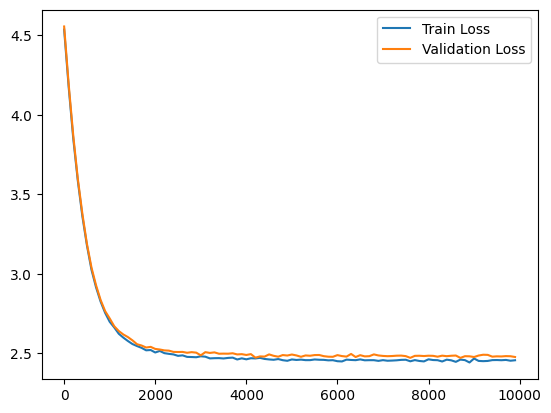

In [99]:
plt.plot([i*100 for i in range(len(history["train"]))], history["train"],label="Train Loss")
plt.plot([i*100 for i in range(len(history["val"]))], history["val"],label="Validation Loss")
plt.legend()
plt.show()

# Model testing

In [87]:
context=torch.zeros((1,1),dtype=torch.long,device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))


Vowag! d opKavzand r ixce? h.

Inthintcen'rst
chend.
BOTofrn-e
ther thar, iros, wazagsws?
Miveror qx?
Tusury be, frur bec-utCofashin, Hxido,beld t hiWary imaima$j-fr e spee cor?whescr'd t knd
uplet bucou!ve; nsDY whe, thowermapearurrv
Pfohlavier h s!
Thom Brel finjSIZowhakshapvenmiger ft?
B.
Be dr I itsins,-they, sidevechyo ang?or beHoun g llllire' theadruraten d y moliroy'nd m!3;shanest yode-LOBude; .
Lathe t we tsth overve!3KI mitharhtos t t buV:
LENUCFnsirs d h wilim-dq; owef pupethor tymeee 
